In [29]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from plotly.subplots import make_subplots
import plotly.graph_objects as go 
import os 
import torch 
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from usr_func import read_file, synchronize_data, make_subplot_data, preprocess_data, split_train_val_test_data, create_sequences
from model.LSTMAutoEncoder import LSTMAutoEncoder

%reload_ext autoreload
%autoreload 2

folder_path = r"C:\Users\nq9093\Downloads\CutFilesToYaolin\CutFilesToYaolin"
files = os.listdir(folder_path)
figpath = os.path.join(os.getcwd(), 'fig')
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [2]:
filenames = []
for file in files: 
    if file.endswith(".cut"): 
        filenames.append(file[:-4])
        file = filenames[0]

# for file in tqdm(filenames): 
#     filepath = os.path.join(folder_path, file)
#     df_accelerometer, df_strain0, df_strain1 = read_file(filepath)
#     df_sync = synchronize_data(df_accelerometer, df_strain0, df_strain1)
#     fig = make_subplot_data(df_sync, filepath, figpath, show=False, save=True)


In [3]:
file = filenames[0]
filepath = os.path.join(folder_path, file)
df_accelerometer, df_strain0, df_strain1 = read_file(filepath)
df_sync = synchronize_data(df_accelerometer, df_strain0, df_strain1)
fig = make_subplot_data(df_sync, filepath, figpath, show=False, save=True)

In [41]:
t_start = 8
t_end = 18
df_selected = df_sync[(df_sync.iloc[:, 0] >= t_start) & (df_sync.iloc[:, 0] <= t_end)]
df_scaled = preprocess_data(df_selected)

df_train, df_val, df_test = split_train_val_test_data(df_scaled, 0.8, .1, .1)

sequence_length = 30
batch_size = 32

columns = ['x2g', 'y2g', 'z2g', 'x50g', 'y50g', 'strain0', 'strain1']
train_dataset = create_sequences(df_train[columns].values, sequence_length)
val_dataset = create_sequences(df_val[columns].values, sequence_length)
test_dataset = create_sequences(df_test[columns].values, sequence_length)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


torch.Size([32, 30, 7])


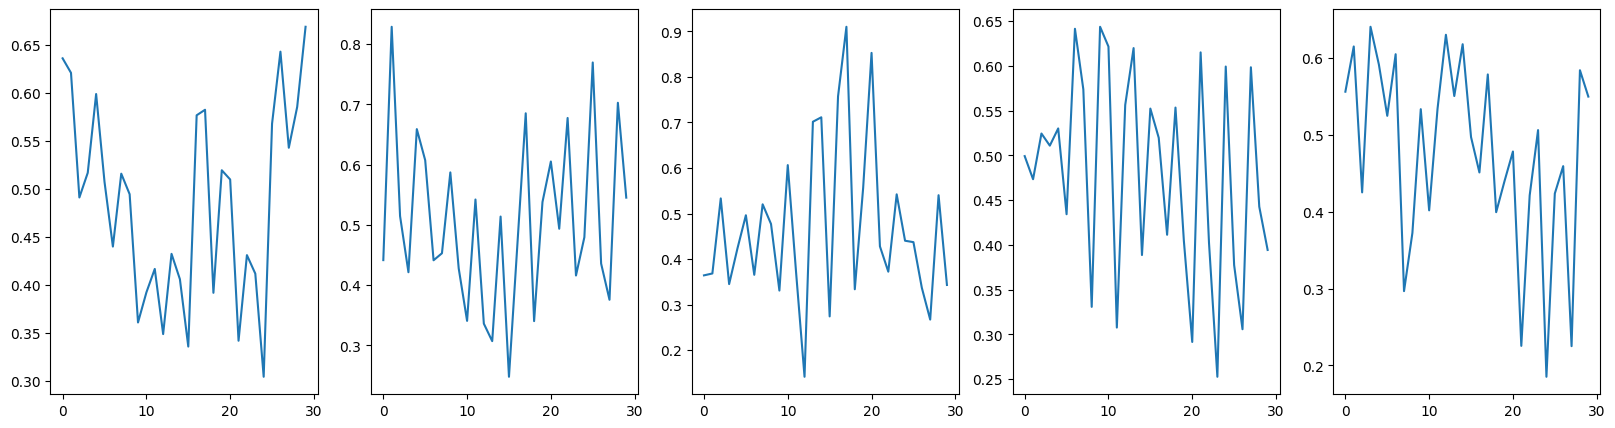

(12800, 8)